In [6]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.8.0+cpu
2.8.0+cpu
cpu


In [ ]:
import os, binascii

SPEECH_FILE = r"C:\Users\user\Desktop\goodmorning.wav"
print("exists:", os.path.exists(SPEECH_FILE), "size:", os.path.getsize(SPEECH_FILE), "bytes")

with open(SPEECH_FILE, "rb") as f:
    header = f.read(16)
print("header hex:", binascii.hexlify(header))

exists: True size: 71938 bytes
header hex: b'00000018667479703367703400000000'


In [ ]:
import librosa

from IPython.display import Audio

SPEECH_FILE = r"C:\Users\user\Desktop\goodmorning.wav"

y, sr = librosa.load(SPEECH_FILE, sr=None, mono=True)
print("librosa loaded:", y.shape, "sr:", sr, "duration(s):", len(y)/sr)

wav = torch.tensor(y, dtype=torch.float32).unsqueeze(0)

Audio(y, rate=sr)


librosa loaded: (117760,) sr: 48000 duration(s): 2.453333333333333


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15780\1789166405.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(SPEECH_FILE, sr=None, mono=True)
c:\Users\user\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
import torchaudio.functional as F
waveform = torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(device)
sample_rate = sr

if sample_rate != bundle.sample_rate:
    waveform = F.resample(waveform, sample_rate, bundle.sample_rate)
    sample_rate = bundle.sample_rate

print("waveform shape:", waveform.shape)
print("sample_rate:", sample_rate)


waveform shape: torch.Size([1, 39254])
sample_rate: 16000


In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

print("Feature tensor shape:", features[0].shape)

Feature tensor shape: torch.Size([1, 122, 768])


In [ ]:
import matplotlib.pyplot as plt

print(f"Number of transformer layers extracted: {len(features)}")

# Create subplots for each transformer layer
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))

if len(features) == 1:
    ax = [ax]

for i, feats in enumerate(features):
    img = feats[0].detach().cpu()
    # Visualize feature representation of each transformer layer
    ax[i].imshow(img.T, aspect="auto", origin="lower", interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Frame (time axis)")
    ax[i].set_ylabel("Feature dimension")

fig.tight_layout()
plt.show()


Number of transformer layers extracted: 12


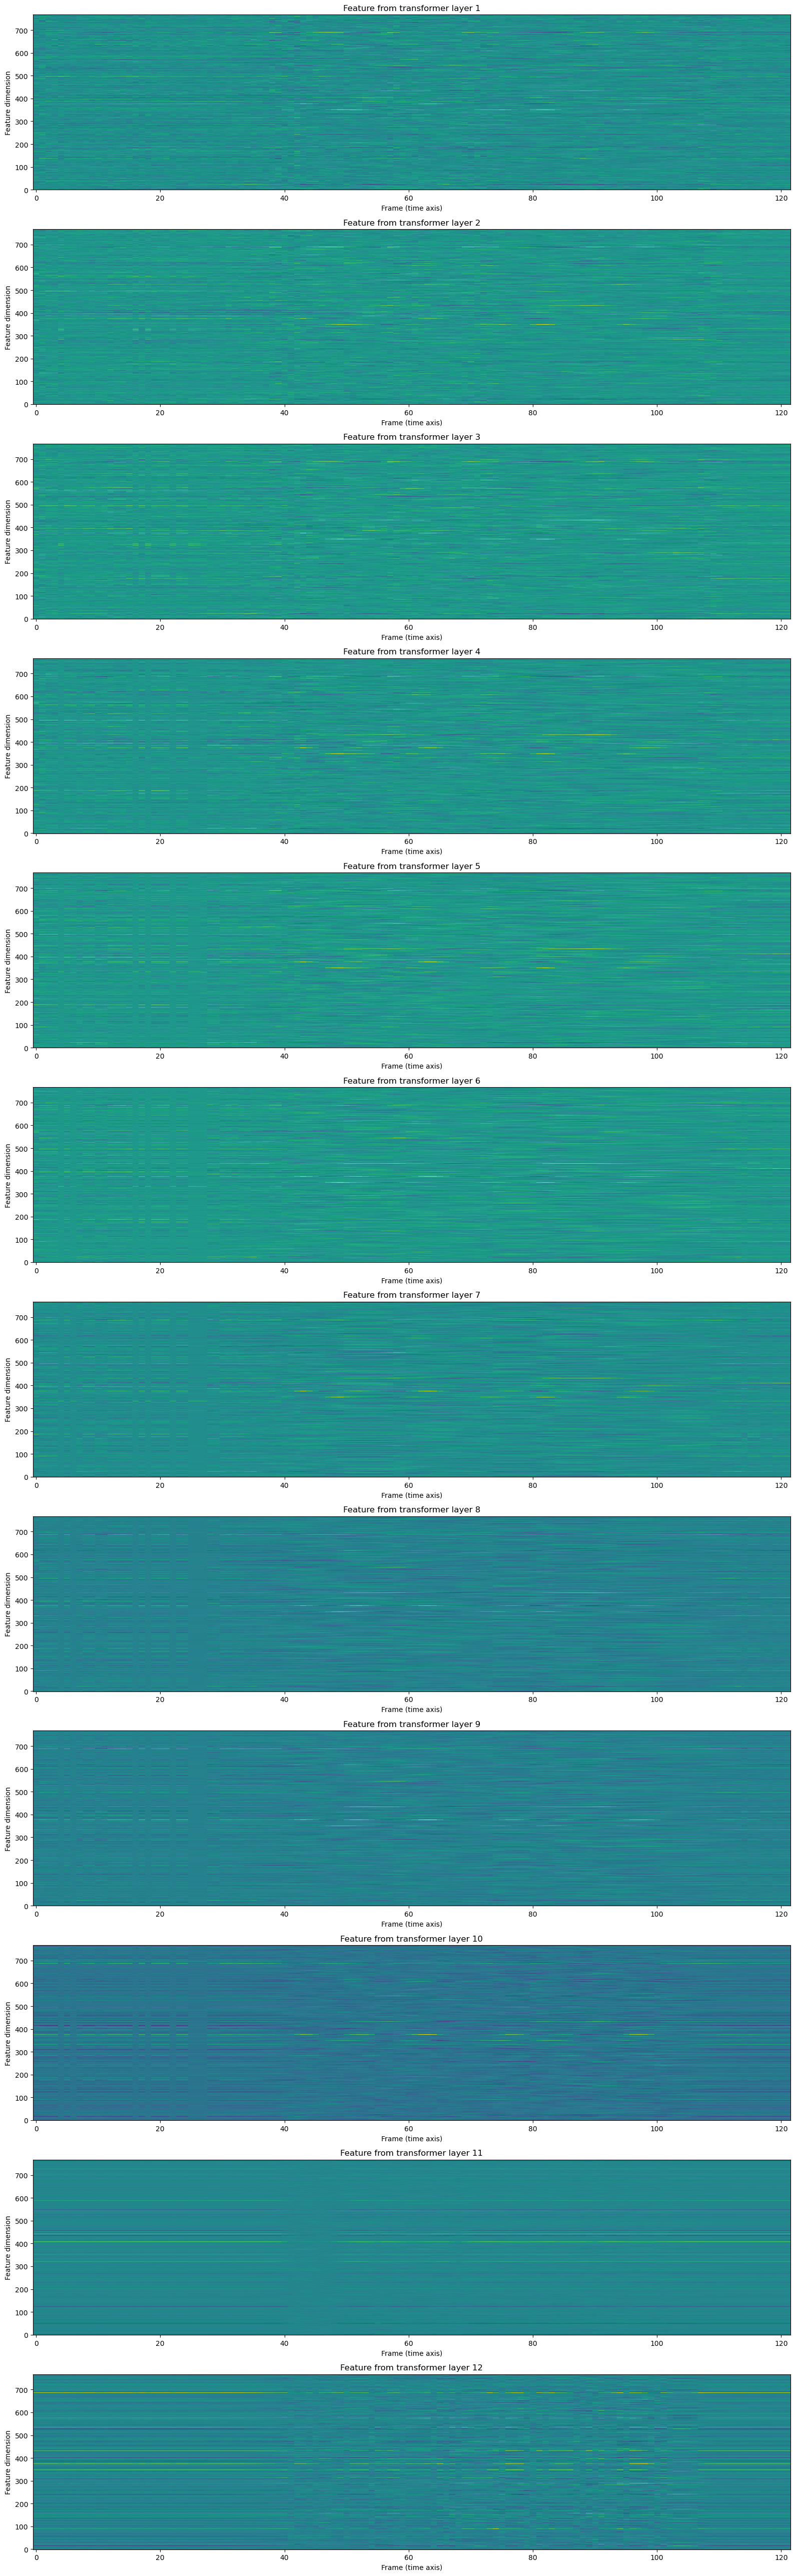

In [39]:
print(f"Number of transformer layers extracted: {len(features)}")

# Create subplots based on number of transformer layers
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))

if len(features) == 1:
    ax = [ax]

for i, feats in enumerate(features):
    img = feats[0].detach().cpu()
    # Visualize feature map of each transformer layer
    ax[i].imshow(img.T, aspect="auto", origin="lower", interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Frame (time axis)")
    ax[i].set_ylabel("Feature dimension")

fig.tight_layout()
plt.show()


In [27]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


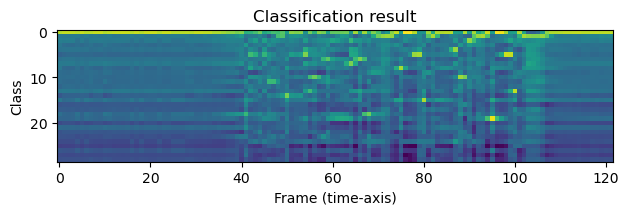

In [36]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [35]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:

        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [30]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [40]:
from IPython.display import Audio
import numpy as np

print("Recognized text:", transcript)

y_play = y
sr_play = sr

try:
    import librosa
    # Resample audio if sample rate is different from model's expected rate
    if sr_play != bundle.sample_rate:
        y_play = librosa.resample(y_play, orig_sr=sr_play, target_sr=bundle.sample_rate)
        sr_play = bundle.sample_rate
except Exception as _:
    pass

# Play the audio (accurate duration display)
Audio(y_play.astype(np.float32), rate=sr_play)


Recognized text: GOOD|MORNING|HOW|ARE|YOU|
